# Exemple supervisé

Entraînement d'un modèle en utilisant uniquement le jeu de données supervisé.
Peut servir de point de départ à un premier essai pour la compétition.

In [1]:
!pip install skorch

In [20]:
!pip list

Package                           Version            
--------------------------------- -------------------
absl-py                           0.9.0              
affine                            2.3.0              
appdirs                           1.4.3              
attrs                             19.3.0             
backcall                          0.1.0              
bleach                            3.1.3              
cachetools                        4.0.0              
certifi                           2019.11.28         
chardet                           3.0.4              
click                             7.1.1              
click-plugins                     1.1.1              
cligj                             0.5.0              
cycler                            0.10.0             
decorator                         4.4.2              
defusedxml                        0.6.0              
entrypoints                       0.3                
Fiona                       

In [21]:
import os
import random
import datetime

In [22]:
import matplotlib.cm
import numpy as np
import scipy
import sklearn
import sklearn.metrics
import sklearn.metrics
import sklearn.preprocessing
import skorch.dataset
import skorch.helper
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [4]:
random.seed(2020)
np.random.seed(2020)
torch.manual_seed(2020)

In [5]:
TRAIN_DATA_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/eurosat_train.npz"

VALID_DATA_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/hackathon-2020/eurosat_valid.npz"

CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

DATASOURCE = np.DataSource(None)

In [6]:
train_dataset = DATASOURCE.open(TRAIN_DATA_URL, "rb")
train_dataset = np.load(train_dataset)

valid_dataset = DATASOURCE.open(VALID_DATA_URL, "rb")
valid_dataset = np.load(valid_dataset)

In [7]:
x_train, y_train = train_dataset['x'], train_dataset['y']
x_valid, y_valid = valid_dataset['x'], valid_dataset['y']

In [8]:
x_train.shape, y_train.shape
x_valid.shape, y_valid.shape

((1500, 64, 64, 3), (1500,))

In [9]:
x_train = x_train.astype(np.float32) / 255.
x_train = x_train.transpose((0, 3, 1, 2))

x_valid = x_valid.astype(np.float32) / 255.
x_valid = x_valid.transpose((0, 3, 1, 2))

# Helper in skorch to use a custom validation dataset instead of splitting the train set
# https://skorch.readthedocs.io/en/stable/user/FAQ.html#i-already-split-my-data-into-training-and-validation-sets-how-can-i-use-them
valid_ds = skorch.dataset.Dataset(x_valid, y_valid)
train_split = skorch.helper.predefined_split(valid_ds)

In [10]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        m.bias.data.fill_(0.1)
    if type(m) == nn.Linear:
        # apply a uniform distribution to the weights and a bias=0
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        m.bias.data.fill_(0.1)


model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8 * 8 * 64, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1),
)

model.apply(init_weights)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Linear(in_features=4096, out_features=256, bias=True)
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Linear(in_features=256, out

In [11]:
lr_scheduler = skorch.callbacks.LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                            factor=0.1,
                                            patience=3)

early_stopping = skorch.callbacks.EarlyStopping(patience=5)

checkpoint_dir = './tmp'
os.makedirs(checkpoint_dir, exist_ok=True)

cp = skorch.callbacks.Checkpoint(dirname=checkpoint_dir)
train_end_cp = skorch.callbacks.TrainEndCheckpoint(dirname=checkpoint_dir)

lr = 0.01
batch_size = 32
max_epochs = 2

net = skorch.NeuralNetClassifier(
    model,
    batch_size=batch_size,
    max_epochs=max_epochs,
    lr=lr,
    train_split=train_split,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
    criterion=nn.modules.loss.NLLLoss,
    optimizer=optim.Adam,
    callbacks=[lr_scheduler, early_stopping, cp, train_end_cp])

In [12]:
net.fit(x_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.6864       0.3027        1.7133     +  4.4877
      2        1.2020       0.3047        2.7131        4.0317


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=4096, out_features=256, bias=True)
    (14): BatchNorm1d(256, eps=1e-05, m

In [13]:
y_pred = net.predict(x_valid)
print(sklearn.metrics.classification_report(y_valid, y_pred, digits=2))
acc = sklearn.metrics.accuracy_score(y_valid, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.06      0.11       150
           1       0.00      0.00      0.00       150
           2       1.00      0.01      0.01       150
           3       0.21      0.59      0.31       150
           4       0.59      0.97      0.74       150
           5       0.00      0.00      0.00       150
           6       0.00      0.00      0.00       150
           7       0.19      0.59      0.28       150
           8       0.14      0.05      0.08       150
           9       0.41      0.78      0.54       150

    accuracy                           0.30      1500
   macro avg       0.35      0.30      0.21      1500
weighted avg       0.35      0.30      0.21      1500



/home/fchouteau/miniconda3/envs/py37-isae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
y_pred_proba = net.predict_proba(x_valid)

In [15]:
y_valid_onehot = sklearn.preprocessing.label_binarize(y_valid, range(10))

In [16]:
# Compute ROC curve and ROC area for each class

def plot_roc_curve(y_test, y_pred, classes):
    n_classes = len(classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += scipy.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = sklearn.metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #     colors = itertools.cycle(['aqua', 'coral', 'gold', 'ivory', 'green', 'blue', 'cyan'])
    colors = matplotlib.cm.get_cmap('Pastel1')
    colors = colors(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

/home/fchouteau/miniconda3/envs/py37-isae/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


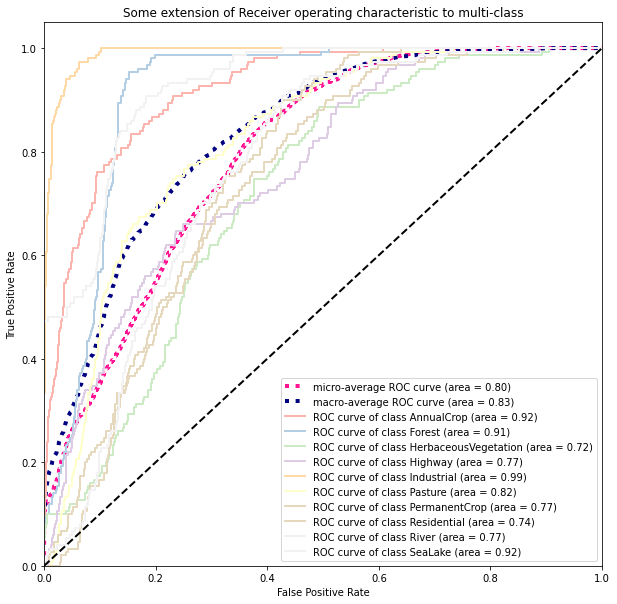

In [17]:
plot_roc_curve(y_valid_onehot, y_pred_proba, CLASSES)

In [18]:
# get and save torch model
model = net.module

In [23]:
torch.save(model, "./model_{}.pt".format(datetime.datetime.now().strftime("%Y%m%d_%H%M")))